<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/gradcameye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModelOCT 

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import PIL
import plotly
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

## เตรียมชุดของข้อมูล

In [3]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/2022Project/for_code'  # data เราอยู่โฟล์เดอร์ไหน

In [5]:
batch_size = 32   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [6]:
# Train
train_dir = "/content/drive/My Drive/2022Project/for_code/train"
train_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 1216 images belonging to 4 classes.


In [7]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[304 304 304 304]


In [8]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [9]:
# Validation
val_dir ="/content/drive/My Drive/2022Project/for_code/validation"
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 152 images belonging to 4 classes.


In [10]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[38 38 38 38]


## Test

In [11]:
# Test
test_dir ="/content/drive/My Drive/2022Project/for_code/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 152 files belonging to 4 classes.


In [12]:
class_names = test_set.class_names
print(class_names)

['CSC', 'Normal', 'PCV', 'VKH']


## Training 

### สร้าง Model

In [13]:
num_classes = 4
epochs=10   # จำนวนครั้งที่เราจะ Train
# ขนาดภาพอินพุตเข้าสู่ Model
in_shape = (256,256,3)
in_shape

(256, 256, 3)

In [14]:
model = Sequential()   # สร้าง Model

# สร้างชั้น Convolution ชั้นแรก ค่าพารามิเตอร์ activation ใช้ ReLU
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = in_shape))
model.add(MaxPool2D((2,2)))    # สร้างชั้น Max Pooling ค่าพารามิเตอร์ 2,2 คือ Pool Size

# ชั้นที่ 2
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPool2D((2,2)))

# ชั้นที่ 3 
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

# FULLY CONNECTED LAYER
model.add(Flatten())

# Output layer
model.add(Dense(4, activation='softmax')) # 4 คลาส
model.summary()          # ดูสรุปโครงสร้าง Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

##### ดู kernel

In [15]:
for layer in model.layers:
  if 'conv' not in layer.name:
       continue
  kernels, biases = layer.get_weights()
  print(layer.name, 'shape:', kernels.shape)

conv2d shape: (3, 3, 3, 16)
conv2d_1 shape: (3, 3, 16, 32)
conv2d_2 shape: (3, 3, 32, 64)


In [16]:
k_min, k_max = kernels.min(), kernels.max()
kernels = (kernels - k_min)/ (k_max - k_min)
kernel_idx = 0
kernel_i = kernels[:, :, 0, kernel_idx]
print(kernel_i.round(2))

[[0.24 0.46 0.69]
 [0.47 0.65 0.61]
 [0.3  0.43 0.23]]


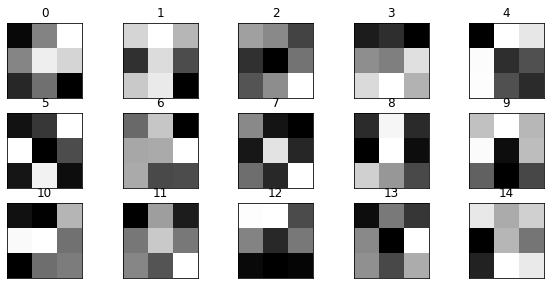

In [17]:
nplots = 15
fig = plt.figure(figsize = (10, 8))
for j in range(nplots):
  plt.subplot(5, 5, j+1)
  plt.imshow(kernels[:, :, 0, j], cmap = plt.cm.gray)
  plt.title(j)
  plt.xticks([]); plt.yticks([])
plt.show()

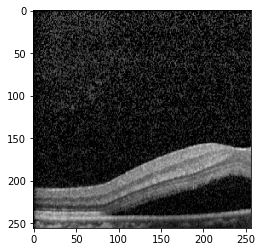

In [18]:
image = load_img('/content/drive/My Drive/2022Project/for_code/train/CSC/IA3870 19-12-16 RE_000_cropped.png', target_size=(256, 256))
plt.imshow(image)
plt.show()

In [19]:
img1 = img_to_array(image)
print('shape =', img1.shape)
print('max pixel value =', np.max(img1))

shape = (256, 256, 3)
max pixel value = 240.0


### Compile และ Train

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
start = time.time()

history = model.fit(train_set, steps_per_epoch=len(train_set), 
                    validation_data=val_set, 
                    epochs=10,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/10
38/38 [==============================] - 17s 353ms/step - loss: 1.1434 - accuracy: 0.5090 - val_loss: 1.6363 - val_accuracy: 0.2368
Epoch 2/10
38/38 [==============================] - 11s 285ms/step - loss: 0.6598 - accuracy: 0.7590 - val_loss: 2.3023 - val_accuracy: 0.3750
Epoch 3/10
38/38 [==============================] - 9s 246ms/step - loss: 0.3409 - accuracy: 0.8947 - val_loss: 2.6709 - val_accuracy: 0.3355
Epoch 4/10
38/38 [==============================] - 9s 237ms/step - loss: 0.1570 - accuracy: 0.9531 - val_loss: 3.3240 - val_accuracy: 0.2632
Epoch 5/10
38/38 [==============================] - 9s 248ms/step - loss: 0.0662 - accuracy: 0.9836 - val_loss: 4.4517 - val_accuracy: 0.2566
Epoch 6/10
38/38 [==============================] - 9s 247ms/step - loss: 0.0335 - accuracy: 0.9918 - val_loss: 4.3315 - val_accuracy: 0.2961
Epoch 7/10
38/38 [==============================] - 9s 236ms/step - loss: 0.0142 - accuracy: 0.9984 - val_loss: 4.8764 - val_accuracy: 0.3158
Epoc

### Save Model

In [22]:
with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='model.h5'
model.save(filepath)
filepath_model = 'model.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_model.h5')
print("Saved model to disk")


Saved model to disk


### Load Model

In [23]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

## ประเมิน

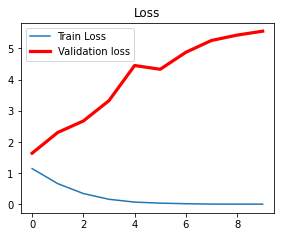

In [24]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

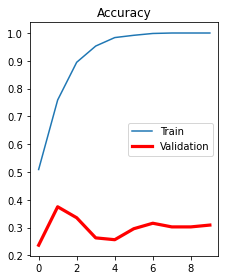

In [25]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.309


### Prediction

In [27]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image
from keras.models import load_model

In [28]:
train_set.class_indices

{'CSC': 0, 'Normal': 1, 'PCV': 2, 'VKH': 3}

In [29]:
# load the saved model
model = load_model('modelOCT.h5')

In [30]:
# load the test image
test_image = image.load_img('/content/drive/My Drive/2022Project/for_code/test/CSC/GD7863 12-16-16 RE_000_cropped.png', target_size=(256, 256))

In [31]:
# preprocess the test image
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

In [32]:
# make predictions
result = model.predict(test_image)

1/1 [==============================] - 0s 168ms/step


In [33]:
# get class labels
class_labels = ['CSC', 'Normal', 'PCV', 'VKH']

In [34]:
# find the index of the predicted class
predicted_class_index = np.argmax(result)

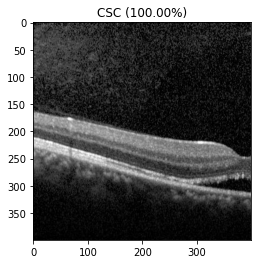

In [35]:
# get the predicted class label
prediction = class_labels[predicted_class_index]

# get the probability of the predicted class
predicted_probability = result[0][predicted_class_index] * 100

# show the test image
plt.imshow(image.load_img('/content/drive/My Drive/2022Project/for_code/test/CSC/GD7863 12-16-16 RE_000_cropped.png'))
plt.title(f'{prediction} ({predicted_probability:.2f}%)')
plt.show()

1/1 [==============================] - 0s 64ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


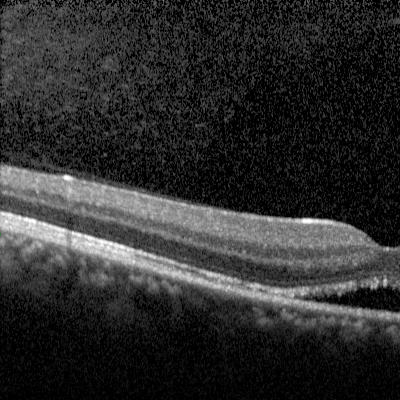

AI CSC มีความมั่นใจ 47.54%.


In [36]:
# CSC
test_path = ('/content/drive/My Drive/2022Project/for_code/test/CSC/GD7863 12-16-16 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536686, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


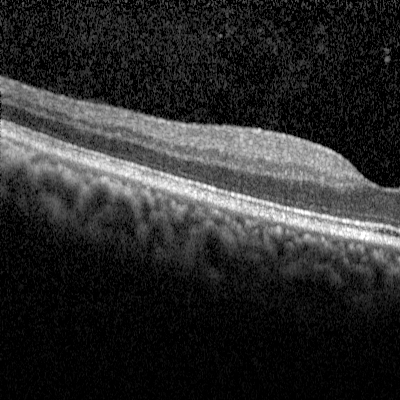

AI Normal มีความมั่นใจ 47.54%.


In [37]:
# Normal
test_path = ('/content/drive/My Drive/2022Project/for_code/test/Normal/CJ5901 24-01-19 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


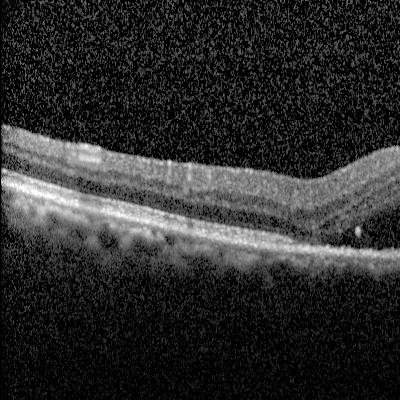

AI CSC มีความมั่นใจ 47.54%.


In [38]:
# PCV
test_path = ('/content/drive/My Drive/2022Project/for_code/test/PCV/AV0940 20-09-16 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


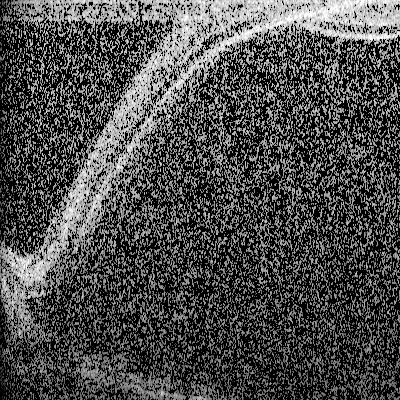

AI CSC มีความมั่นใจ 47.54%.


In [39]:
# VKH
test_path = ('/content/drive/My Drive/2022Project/for_code/test/VKH/KI2719 02-02-21 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [40]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "Normal"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 24ms/step


In [41]:
print(y_test)
print(len(y_test))

['Normal', 'PCV', 'CSC', 'Normal', 'CSC', 'PCV', 'Normal', 'Normal', 'Normal', 'PCV', 'PCV', 'Normal', 'CSC', 'PCV', 'VKH', 'PCV', 'Normal', 'Normal', 'CSC', 'CSC', 'PCV', 'Normal', 'Normal', 'VKH', 'PCV', 'CSC', 'PCV', 'CSC', 'CSC', 'VKH', 'PCV', 'Normal', 'VKH', 'Normal', 'Normal', 'Normal', 'PCV', 'VKH', 'CSC', 'Normal', 'VKH', 'VKH', 'VKH', 'VKH', 'PCV', 'PCV', 'PCV', 'PCV', 'VKH', 'CSC', 'PCV', 'CSC', 'VKH', 'Normal', 'Normal', 'Normal', 'PCV', 'Normal', 'CSC', 'CSC', 'PCV', 'Normal', 'VKH', 'VKH', 'CSC', 'CSC', 'CSC', 'CSC', 'PCV', 'CSC', 'Normal', 'CSC', 'CSC', 'Normal', 'PCV', 'PCV', 'CSC', 'CSC', 'Normal', 'VKH', 'Normal', 'CSC', 'PCV', 'PCV', 'CSC', 'Normal', 'CSC', 'Normal', 'PCV', 'VKH', 'VKH', 'PCV', 'Normal', 'Normal', 'VKH', 'Normal', 'VKH', 'CSC', 'VKH', 'CSC', 'CSC', 'PCV', 'VKH', 'VKH', 'PCV', 'VKH', 'PCV', 'CSC', 'VKH', 'Normal', 'VKH', 'Normal', 'VKH', 'VKH', 'Normal', 'PCV', 'CSC', 'VKH', 'Normal', 'VKH', 'Normal', 'VKH', 'PCV', 'CSC', 'Normal', 'PCV', 'Normal', 'C

In [42]:
print(y_pred)
print(len(y_pred))

['Normal', 'CSC', 'CSC', 'Normal', 'VKH', 'CSC', 'Normal', 'Normal', 'VKH', 'PCV', 'PCV', 'Normal', 'CSC', 'PCV', 'VKH', 'Normal', 'Normal', 'VKH', 'CSC', 'CSC', 'CSC', 'PCV', 'Normal', 'PCV', 'PCV', 'CSC', 'CSC', 'CSC', 'CSC', 'VKH', 'PCV', 'Normal', 'VKH', 'Normal', 'PCV', 'Normal', 'PCV', 'VKH', 'VKH', 'Normal', 'Normal', 'Normal', 'VKH', 'PCV', 'CSC', 'PCV', 'PCV', 'PCV', 'VKH', 'CSC', 'PCV', 'CSC', 'VKH', 'Normal', 'Normal', 'VKH', 'CSC', 'Normal', 'CSC', 'CSC', 'CSC', 'Normal', 'VKH', 'VKH', 'CSC', 'PCV', 'CSC', 'CSC', 'PCV', 'CSC', 'Normal', 'VKH', 'VKH', 'Normal', 'PCV', 'CSC', 'CSC', 'CSC', 'VKH', 'VKH', 'Normal', 'CSC', 'PCV', 'PCV', 'VKH', 'PCV', 'CSC', 'PCV', 'PCV', 'VKH', 'VKH', 'PCV', 'Normal', 'PCV', 'VKH', 'VKH', 'CSC', 'CSC', 'VKH', 'VKH', 'VKH', 'CSC', 'PCV', 'VKH', 'PCV', 'VKH', 'PCV', 'PCV', 'VKH', 'VKH', 'VKH', 'Normal', 'VKH', 'VKH', 'Normal', 'PCV', 'CSC', 'VKH', 'Normal', 'PCV', 'VKH', 'CSC', 'CSC', 'CSC', 'Normal', 'PCV', 'Normal', 'CSC', 'CSC', 'CSC', 'VKH', '

## Confusion Matrix

In [43]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
confusion_matrix(y_test, y_pred)

array([[27,  0,  3,  8],
       [ 0, 26,  5,  7],
       [13,  1, 24,  0],
       [ 4,  2,  5, 27]])

In [45]:
cm = confusion_matrix(y_test, y_pred)

In [46]:
test_set.class_names

['CSC', 'Normal', 'PCV', 'VKH']

In [47]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'Normal', 'PCV', 'VKH'], 
                     columns = ['CSC', 'Normal', 'PCV', 'VKH'])

In [48]:
cm_df

,CSC,Normal,PCV,VKH
CSC,27,0,3,8
Normal,0,26,5,7
PCV,13,1,24,0
VKH,4,2,5,27


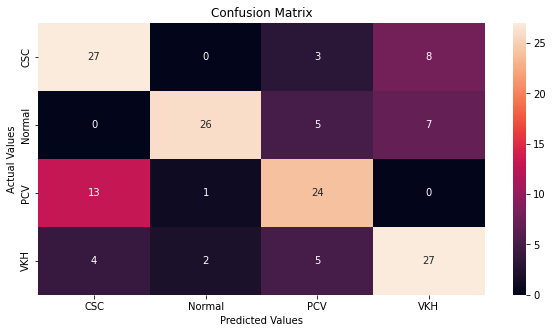

In [49]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

##  misclassify

In [50]:
# แสดง misclassify ว่ามีกี่ค่า
misclassify = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            misclassify += cm[i][j]
            
print('misclassification: ', misclassify)

misclassification:  48


In [51]:
# คำนวณค่า misclassification
misclassify = 1 - np.trace(cm) / np.sum(cm)

# Misclassification rate = จำนวนภาพที่ถูกจัดหมวดหมู่ผิด / จำนวนภาพทั้งหมดที่ใช้ในการทดสอบ

# แสดงผลลัพธ์ที่คิดเป็น %
print("Misclassification: {:.2f}%".format(misclassify*100))

Misclassification: 31.58%


In [52]:
!pip install python-helpers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
import cv2 # computer vision library
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
%matplotlib inline

In [54]:
# ไดเร็กทอรีข้อมูลรูปภาพ
image_dir_training  =  "/content/drive/My Drive/2022Project/for_code/train/" 
image_dir_test  =  "/content/drive/My Drive/2022Project/for_code/test/"

In [55]:
# โหลดข้อมูลการฝึกอบรม
IMAGE_LIST = keras.models.load_model('modelOCT.h5')

In [56]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [57]:
# กำหนด path ของชุดข้อมูลทดสอบ
test_path = "path/to/test/directory"

# กำหนด path ของโฟลเดอร์ที่จะเก็บรูปภาพที่ทำนายผิด
output_folder = "path/to/output/directory"

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [59]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.684211


In [60]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.684211


In [61]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.700423


In [62]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.687414


## Grad-CAM

In [164]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import tensorflow as tf

In [165]:
# Load model and weights
model = load_model('model.h5')
model.load_weights('weights_model.h5')

In [183]:
# Define target size for resizing image
target_size = (256, 256)

In [184]:
# Define class names
class_names = ['CSC', 'Normal', 'PCV', 'VKH']

In [185]:
# Load image from drive and resize
img_path = "/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png"
img = image.load_img(img_path, target_size=target_size)

In [186]:
# Convert image to array and preprocess
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)

# Expand dimensions to match model input shape
img_array = np.expand_dims(img_array, axis=0)

# Create gradient model with outputs from last convolutional layer and model predictions
last_conv_layer = model.get_layer('conv2d_2')
gradient_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])


In [187]:
# Calculate gradients with respect to last convolutional layer output
with tf.GradientTape() as tape:
    conv_output, predictions = gradient_model(img_array)
    loss = predictions[:, np.argmax(predictions[0])]
grads = tape.gradient(loss, conv_output)[0]


In [188]:
# Calculate global average pooling of gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Calculate weighted output of last convolutional layer
weighted_output = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)


In [189]:
# Apply ReLU activation function
weighted_output = tf.maximum(weighted_output, 0)

# Normalize weights
weighted_output /= tf.reduce_max(weighted_output)

In [190]:
# Resize weighted output to match original image size
weighted_output = tf.image.resize(weighted_output, target_size)

# Convert weighted output to numpy array
weighted_output = weighted_output.numpy()

แปลงภาพเป็นชนิด CV_8UC1 หรือ CV_8UC3 ก่อนจึงนำภาพไปใช้กับฟังก์ชัน cv2.applyColorMap()

In [191]:
import cv2

img = cv2.imread('/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png') # อ่านภาพจากไฟล์
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # แปลงภาพเป็น grayscale

# นำภาพ grayscale ไปใช้กับฟังก์ชัน applyColorMap
heatmap = cv2.applyColorMap(img_gray, cv2.COLORMAP_JET)

In [199]:
# Blend heatmap with original image
superimposed_img = cv2.addWeighted(np.uint8(255*img_array[0]), 0.6, heatmap, 0.4, 0)

error: ignored

In [196]:
# Display result
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

NameError: ignored